<a href="https://colab.research.google.com/github/jvitorbarros15/nfl-4th-down-predictor/blob/main/NFLPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [216]:
import os
import glob, re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Downloading the Dataset

In [217]:
!pip install kaggle
!pip install -q --upgrade kagglehub[pandas-datasets]

In [218]:
import kagglehub


path = kagglehub.dataset_download("joaov21/nfl-play-by-play-20132024-merged-dataset")

print("📂 Path to dataset files:", path)


Using Colab cache for faster access to the 'nfl-play-by-play-20132024-merged-dataset' dataset.
📂 Path to dataset files: /kaggle/input/nfl-play-by-play-20132024-merged-dataset


## 1) Data Loading

In [219]:
df = pd.read_parquet(f"{path}/nfl_pbp_2013_2024.parquet")

df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,Season
0,2013122913,2013-12-29,3,15,0,DEN,LV,1,10,20,...,0.0,RIGHT END,20.0,OWN,0.0,None,0.0,None,0.0,2013
1,2013122913,2013-12-29,2,0,13,DEN,LV,0,0,35,...,0.0,None,35.0,OWN,0.0,None,0.0,None,0.0,2013
2,2013122913,2013-12-29,2,0,13,DEN,LV,0,0,98,...,0.0,None,2.0,OPP,0.0,None,0.0,None,0.0,2013
3,2013122913,2013-12-29,2,0,18,DEN,LV,1,5,95,...,0.0,None,5.0,OPP,0.0,None,0.0,None,0.0,2013
4,2013122913,2013-12-29,2,0,22,DEN,LV,2,4,89,...,0.0,None,11.0,OPP,0.0,None,0.0,None,0.0,2013


In [220]:
df.shape

(485026, 46)

In [221]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485026 entries, 0 to 485025
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   GameId                          485026 non-null  int64  
 1   GameDate                        485026 non-null  object 
 2   Quarter                         485026 non-null  int64  
 3   Minute                          485026 non-null  int64  
 4   Second                          485026 non-null  int64  
 5   OffenseTeam                     454327 non-null  object 
 6   DefenseTeam                     474095 non-null  object 
 7   Down                            485026 non-null  int64  
 8   ToGo                            485026 non-null  int64  
 9   YardLine                        485026 non-null  int64  
 10  Unnamed: 10                     0 non-null       float64
 11  SeriesFirstDown                 485025 non-null  float64
 12  Unnamed: 12     

In [222]:
df.isna().sum()


,0
GameId,0
GameDate,0
Quarter,0
Minute,0
Second,0
OffenseTeam,30699
DefenseTeam,10931
Down,0
ToGo,0
YardLine,0


## 2) Data Cleaning

In [223]:
df_clean = df.copy()
df_clean.drop(df_clean.columns[[10, 12, 16, 17]], axis=1, inplace=True)


In [224]:
df_clean.columns


Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'SeriesFirstDown',
       'NextScore', 'Description', 'TeamWin', 'SeasonYear', 'Yards',
       'Formation', 'PlayType', 'IsRush', 'IsPass', 'IsIncomplete',
       'IsTouchdown', 'PassType', 'IsSack', 'IsChallenge',
       'IsChallengeReversed', 'Challenger', 'IsMeasurement', 'IsInterception',
       'IsFumble', 'IsPenalty', 'IsTwoPointConversion',
       'IsTwoPointConversionSuccessful', 'RushDirection', 'YardLineFixed',
       'YardLineDirection', 'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay',
       'PenaltyType', 'PenaltyYards', 'Season'],
      dtype='object')

## 3) Identifying 4th Down Attempts

In [225]:
df_clean['is_4th_down'] = (df_clean['Down'] == 4).astype(int)

In [226]:
df_clean.count()

,0
GameId,485026
GameDate,485026
Quarter,485026
Minute,485026
Second,485026
OffenseTeam,454327
DefenseTeam,474095
Down,485026
ToGo,485026
YardLine,485026


In [227]:
df_clean.isna().sum()

,0
GameId,0
GameDate,0
Quarter,0
Minute,0
Second,0
OffenseTeam,30699
DefenseTeam,10931
Down,0
ToGo,0
YardLine,0


In [228]:
df_clean = df_clean.dropna(subset=['OffenseTeam', 'DefenseTeam'])


In [229]:
df_clean.isna().sum()

,0
GameId,0
GameDate,0
Quarter,0
Minute,0
Second,0
OffenseTeam,0
DefenseTeam,0
Down,0
ToGo,0
YardLine,0


In [230]:
# total before cleaning
original_len = len(df)

# total after cleaning
cleaned_len = len(df_clean)

kept_pct = (cleaned_len / original_len) * 100
dropped_pct = 100 - kept_pct

print(f"✅ Remaining data: {kept_pct:.2f}%")
print(f"🗑️ Dropped data: {dropped_pct:.2f}%")


✅ Remaining data: 93.67%
🗑️ Dropped data: 6.33%


## 4) Feature Engineering

In [231]:

num = ['Down','Minute','Second','IsRush','IsPass','IsNoPlay','IsTouchdown']
for c in num:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').fillna(0).astype(int)

df_clean = df_clean.sort_values(
    ['GameId','Quarter','Minute','Second'],
    ascending=[True, True, False, False]
).reset_index(drop=True)

is_4th = df_clean['is_4th_down'].astype(int).eq(1) if 'is_4th_down' in df_clean else df_clean['Down'].eq(4)
is_attempt = ((df_clean['IsRush'] == 1) | (df_clean['IsPass'] == 1)) & (df_clean['IsNoPlay'] == 0)
mask_4th_attempt = is_4th & is_attempt


g = df_clean.groupby('GameId', group_keys=False)
df_clean['NextDown'] = g['Down'].shift(-1)
df_clean['NextOffenseTeam'] = g['OffenseTeam'].shift(-1)

success_simple = (
    (df_clean['OffenseTeam'] == df_clean['NextOffenseTeam']) &
    (df_clean['NextDown'] == 1)
) | (df_clean['IsTouchdown'] == 1)

df_clean['FourthDownSuccess_simple'] = (mask_4th_attempt & success_simple).astype(int)

print("Total 4th-down plays:", int(is_4th.sum()))
print("4th-down go-for-it attempts (Run/Pass):", int(mask_4th_attempt.sum()))
print("Labeled successes:", int(df_clean.loc[mask_4th_attempt, 'FourthDownSuccess_simple'].sum()))
print("Conversion rate:", df_clean.loc[mask_4th_attempt, 'FourthDownSuccess_simple'].mean())


Total 4th-down plays: 40372
4th-down go-for-it attempts (Run/Pass): 5607
Labeled successes: 2937
Conversion rate: 0.5238095238095238


In [232]:
is_4th = (df_clean['is_4th_down'].astype(int).eq(1)) if 'is_4th_down' in df_clean.columns else df_clean['Down'].eq(4)
is_play = df_clean['IsRush'].eq(1) | df_clean['IsPass'].eq(1)
is_noplay = df_clean['IsNoPlay'].eq(1) if 'IsNoPlay' in df_clean.columns else False
mask_4th_attempt = is_4th & is_play & ~is_noplay

attempts = df_clean.loc[mask_4th_attempt].copy()


In [233]:
for col in ['ToGo','YardLine','IsRush','IsPass','Minute','Second','Quarter']:
    if col in attempts.columns:
        attempts[col] = pd.to_numeric(attempts[col], errors='coerce').fillna(0)


if 'FourthDownSuccess_simple' in attempts.columns:
    attempts['FourthDownSuccess_simple'] = (
        attempts['FourthDownSuccess_simple']
        .fillna(0)
        .astype(int)
    )

# Feature engineering
if 'ToGo' in attempts.columns:
    attempts['ShortYards'] = (attempts['ToGo'] <= 2).astype(int)

if 'YardLine' in attempts.columns:
    attempts['RedZone']  = (attempts['YardLine'] >= 80).astype(int)
    attempts['InOwnHalf']= (attempts['YardLine'] < 50).astype(int)

if {'Quarter','Minute'}.issubset(attempts.columns):
    attempts['LateGame'] = ((attempts['Quarter'] >= 4) & (attempts['Minute'] <= 5)).astype(int)

if {'Quarter','Minute','Second'}.issubset(attempts.columns):
    attempts['Clock'] = (attempts['Quarter']*900 - (attempts['Minute']*60 + attempts['Second'])).astype(int)

base_feats  = ['ToGo','YardLine']
maybe_feats = ['IsRush','IsPass','ShortYards','InOwnHalf','RedZone','LateGame','Clock']
features    = [f for f in base_feats + maybe_feats if f in attempts.columns]
print("Using features:", features)


attempts['PlayTypeSimple'] = np.select(
    [attempts['IsPass'].eq(1), attempts['IsRush'].eq(1)],
    ['Pass', 'Run'],
    default='Other'
)

#  keep only clean pass/run rows
attempts_clean_types = attempts[attempts['PlayTypeSimple'] != 'Other'].copy()

type_rates = (
    attempts_clean_types
      .groupby('PlayTypeSimple')['FourthDownSuccess_simple']
      .agg(count='size', mean='mean', successes=lambda s: int((s==1).sum()))
)
type_rates['rate'] = type_rates['successes'] / type_rates['count']
print(type_rates[['count','successes','rate']])

Using features: ['ToGo', 'YardLine', 'IsRush', 'IsPass', 'ShortYards', 'InOwnHalf', 'RedZone', 'LateGame', 'Clock']
                count  successes      rate
PlayTypeSimple                            
Pass             3534       1552  0.439162
Run              2073       1385  0.668114


In [234]:
base_feats  = ['ToGo','YardLine']
maybe_feats = ['IsRush','IsPass','ShortYards','InOwnHalf','RedZone','LateGame','Clock']
features    = [f for f in base_feats + maybe_feats if f in attempts.columns]
print("Using features:", features)

Using features: ['ToGo', 'YardLine', 'IsRush', 'IsPass', 'ShortYards', 'InOwnHalf', 'RedZone', 'LateGame', 'Clock']


## 5) Exploratory Analysis

In [235]:
overall = attempts['FourthDownSuccess_simple'].mean()
print(f"Overall conversion rate: {overall:.2%}")

team_rates = (attempts
              .groupby('OffenseTeam')['FourthDownSuccess_simple']
              .agg(['mean','count'])
              .rename(columns={'mean':'conv_rate','count':'attempts'})
              .sort_values('conv_rate', ascending=False))
team_rates


Overall conversion rate: 52.38%


,conv_rate,attempts
OffenseTeam,,
KC,0.604839,124
BAL,0.592814,167
NO,0.584416,154
ATL,0.579545,176
DEN,0.571429,168
IND,0.563830,188
WAS,0.558511,188
CAR,0.556650,203
LAC,0.554054,148


In [236]:
# Conversion rates by play type (Pass vs Run)
type_rates = (
    attempts_clean_types
      .groupby('PlayTypeSimple')['FourthDownSuccess_simple']
      .agg(count='size', mean='mean', successes=lambda s: int((s==1).sum()))
)
type_rates['rate'] = type_rates['successes'] / type_rates['count']
print(type_rates[['count','successes','rate']])

                count  successes      rate
PlayTypeSimple                            
Pass             3534       1552  0.439162
Run              2073       1385  0.668114


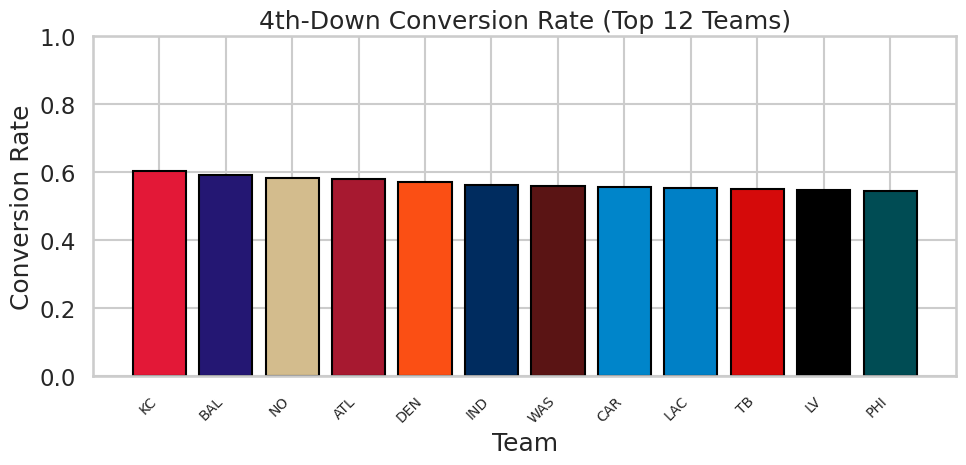

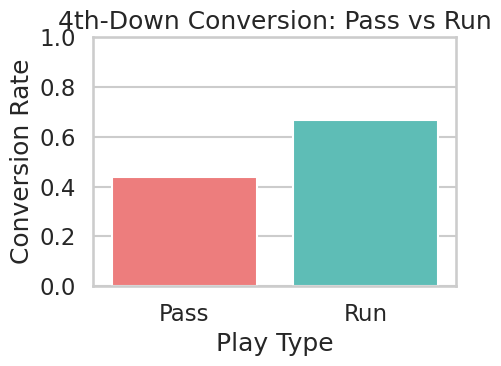

In [237]:
team_colors = {
    'ARI': '#97233F', 'ATL': '#A71930', 'BAL': '#241773', 'BUF': '#00338D',
    'CAR': '#0085CA', 'CHI': '#0B162A', 'CIN': '#FB4F14', 'CLE': '#311D00',
    'DAL': '#041E42', 'DEN': '#FB4F14', 'DET': '#0076B6', 'GB': '#203731',
    'HOU': '#03202F', 'IND': '#002C5F', 'JAX': '#006778', 'KC': '#E31837',
    'LAC': '#0080C6', 'LAR': '#003594', 'LV': '#000000', 'MIA': '#008E97',
    'MIN': '#4F2683', 'NE': '#002244', 'NO': '#D3BC8D', 'NYG': '#0B2265',
    'NYJ': '#125740', 'PHI': '#004C54', 'PIT': '#FFB612', 'SEA': '#002244',
    'SF': '#AA0000', 'TB': '#D50A0A', 'TEN': '#4B92DB', 'WAS': '#5A1414'
}


# Conversion Rate top 12 teams
top = team_rates.sort_values('conv_rate', ascending=False).head(12)

colors = [team_colors.get(team, '#333333') for team in top.index]

plt.figure(figsize=(10,5))
plt.bar(top.index, top['conv_rate'].values, color=colors, edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0,1)
plt.title('4th-Down Conversion Rate (Top 12 Teams)')
plt.ylabel('Conversion Rate')
plt.xlabel('Team')
plt.tight_layout()
plt.show()

# Pass vs Run
palette = {'Pass': '#FF6B6B', 'Run': '#4ECDC4', 'Other': 'gray'}

# Convert to DataFrame for seaborn
type_rate_series = type_rates['rate'] if 'rate' in type_rates.columns else type_rates.squeeze()
df_plot = type_rate_series.reset_index()
df_plot.columns = ['PlayType', 'Rate']

plt.figure(figsize=(5,4))
sns.barplot(
    data=df_plot,
    x='PlayType',
    y='Rate',
    hue='PlayType',
    palette=palette,
    legend=False
)
plt.ylim(0,1)
plt.xlabel('Play Type')
plt.ylabel('Conversion Rate')
plt.title('4th-Down Conversion: Pass vs Run')
plt.tight_layout()
plt.show()




In [238]:
attempts['Yards'] = pd.to_numeric(attempts['Yards'], errors='coerce').fillna(0).astype(int)

def yards_to_class(y):
    if y <= 0:  return 0
    if y >= 16: return 16
    return int(y)

attempts['YardsClass'] = attempts['Yards'].apply(yards_to_class)


## 6) Model Training (XGBoost)

In [239]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import numpy as np

X = attempts[features].fillna(0)
y = attempts['YardsClass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

xgb = XGBClassifier(
    objective='multi:softprob', num_class=17,
    eval_metric='mlogloss',
    learning_rate=0.05, max_depth=5, n_estimators=400,
    subsample=0.8, colsample_bytree=0.8, tree_method='hist'
)
xgb.fit(X_train, y_train)

proba = xgb.predict_proba(X_test)
togo = X_test['ToGo'].astype(int).values

# P(convert) = sum P(yards >= ToGo)
P_conv = np.array([p[16] if d >= 16 else p[d:].sum() for p, d in zip(proba, togo)])
P_conv = np.clip(P_conv, 0, 1)

# Ground-truth binary conversion for the same rows
y_true_conv = (attempts.loc[X_test.index, 'FourthDownSuccess_simple'] == 1).astype(int).values
print("Brier score:", brier_score_loss(y_true_conv, P_conv))


Brier score: 0.2435841287241322


## 7) Trying more feature engineering to get more accuracy

In [240]:
df_clean['ScoreChange'] = 0

# Touchdowns
df_clean.loc[df_clean['IsTouchdown'] == 1, 'ScoreChange'] = 6

# Successful 2-point conversions
df_clean.loc[df_clean['IsTwoPointConversionSuccessful'] == 1, 'ScoreChange'] += 2

# Field Goals
df_clean.loc[df_clean['PlayType'].str.contains('FIELD GOAL', case=False, na=False), 'ScoreChange'] = 3

# Safeties
df_clean.loc[df_clean['Description'].str.contains('SAFETY', case=False, na=False), 'ScoreChange'] = -2


In [241]:
df_clean['OffenseScoreAdd'] = 0
df_clean['DefenseScoreAdd'] = 0

# Positive change = offense scored
df_clean.loc[df_clean['ScoreChange'] > 0, 'OffenseScoreAdd'] = df_clean['ScoreChange']

# Negative change = defense scored
df_clean.loc[df_clean['ScoreChange'] < 0, 'DefenseScoreAdd'] = abs(df_clean['ScoreChange'])


In [242]:
df_clean['OffenseScore'] = df_clean.groupby('GameId')['OffenseScoreAdd'].cumsum()
df_clean['DefenseScore'] = df_clean.groupby('GameId')['DefenseScoreAdd'].cumsum()


In [243]:
df_clean['ScoreDiff'] = df_clean['OffenseScore'] - df_clean['DefenseScore']

# Simple WP proxy used by NFL research teams:
df_clean['WpSimple'] = 1 / (1 + np.exp(-df_clean['ScoreDiff'] / 7))


In [244]:
for col in ['ScoreDiff','WpSimple']:
    if col in df_clean.columns:
        attempts[col] = df_clean.loc[mask_4th_attempt, col].values

In [245]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split

# Ensure the model sees only valid 4th down go-for-it attempts


X = attempts[features].fillna(0)
y = attempts['FourthDownSuccess_simple']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_label))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print("Brier Score:", brier_score_loss(y_test, y_pred_prob))



Accuracy: 0.6226975638740344
ROC-AUC: 0.6565511776071115
Brier Score: 0.22927909385534725


## 7) Model Evaluation (Accuracy, ROC, Brier Score)

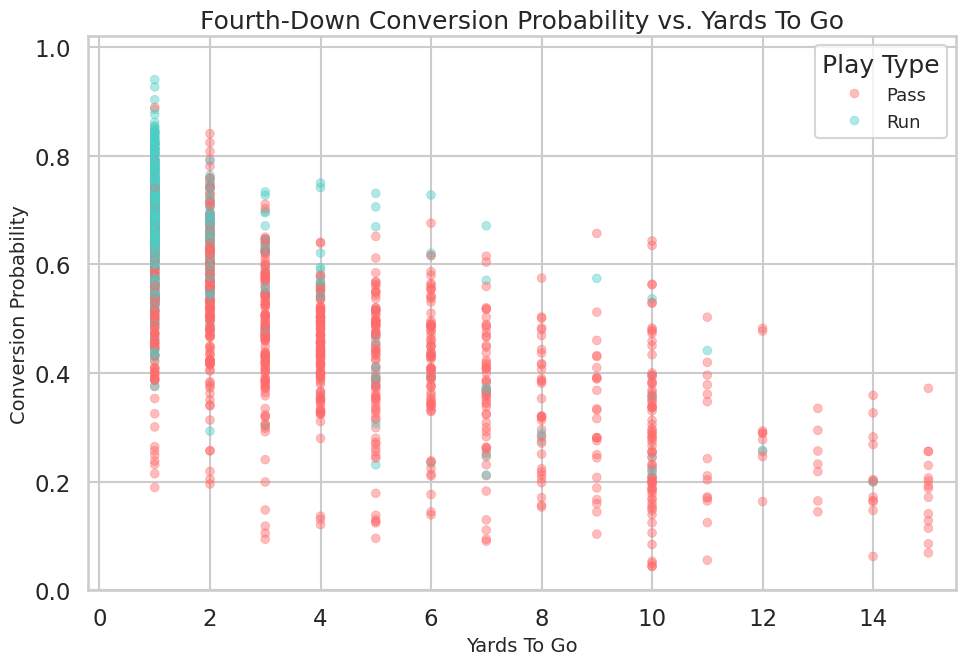

In [246]:
y_prob = model.predict_proba(X_test)[:, 1]

# 2) Build plotting DataFrame
plot_df = X_test[['ToGo', 'IsPass', 'IsRush']].copy()
plot_df = plot_df.assign(prob=y_prob)

# 3) Play-type color grouping
plot_df['Play'] = np.where(plot_df['IsPass']==1, 'Pass',
                    np.where(plot_df['IsRush']==1, 'Run', 'Other'))

# 4) Keep plausible range + optional downsample
plot_df = plot_df.query('ToGo <= 15').copy()
if len(plot_df) > 20000:
    plot_df = plot_df.sample(20000, random_state=42)

# 5) Nice seaborn style
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=plot_df,
    x='ToGo', y='prob',
    hue='Play',
    palette={'Pass': '#FF6B6B', 'Run': '#4ECDC4', 'Other': 'gray'},
    alpha=0.45,
    s=40,
    edgecolor=None
)

# Polished labels + bounds
plt.xlabel('Yards To Go', fontsize=14)
plt.ylabel('Conversion Probability', fontsize=14)
plt.title('Fourth-Down Conversion Probability vs. Yards To Go', fontsize=18)
plt.xlim(-0.2, 15.5)
plt.ylim(0, 1.02)

# Cleaner legend
plt.legend(title='Play Type', loc='upper right', frameon=True, fontsize=13)
plt.tight_layout()
plt.show()

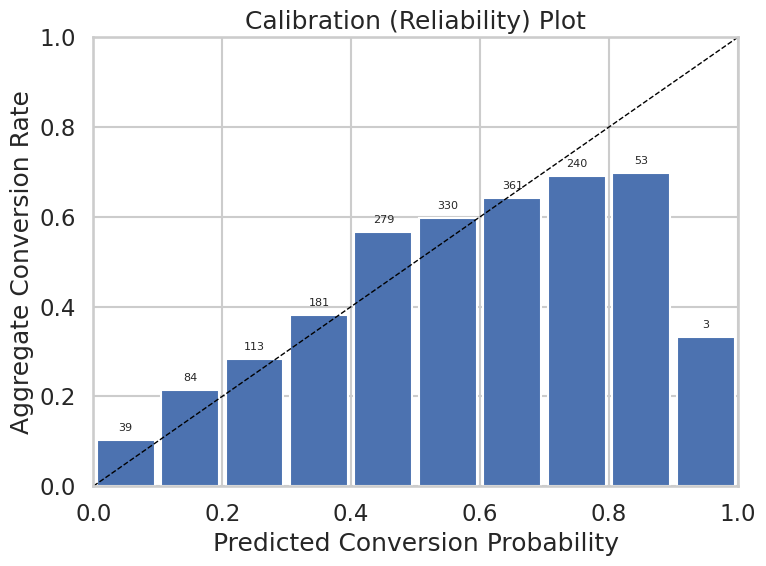

In [247]:
# Combine y_test with predictions
cal_df = pd.DataFrame({'prob': y_prob, 'y': y_test.values})

# 10 equal-width bins: [0–0.1), [0.1–0.2), … [0.9–1.0]
bins = np.linspace(0, 1, 11)
cal_df['bin'] = pd.cut(cal_df['prob'], bins=bins, include_lowest=True, right=False)

cal_stats = (cal_df
             .groupby('bin', observed=True)
             .agg(actual_rate=('y','mean'), n=('y','size'))
            )


cal_stats['mid'] = [interval.left + (interval.right-interval.left)/2 for interval in cal_stats.index]
bar_width = 0.09

plt.figure(figsize=(8,6))
plt.bar(cal_stats['mid'], cal_stats['actual_rate'], width=bar_width, align='center')
plt.plot([0,1],[0,1], '--', linewidth=1, color='black')


for x, yv, cnt in zip(cal_stats['mid'], cal_stats['actual_rate'], cal_stats['n']):
    plt.text(x, yv+0.015, str(cnt), ha='center', va='bottom', fontsize=8)

plt.xlabel('Predicted Conversion Probability')
plt.ylabel('Aggregate Conversion Rate')
plt.title('Calibration (Reliability) Plot')
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


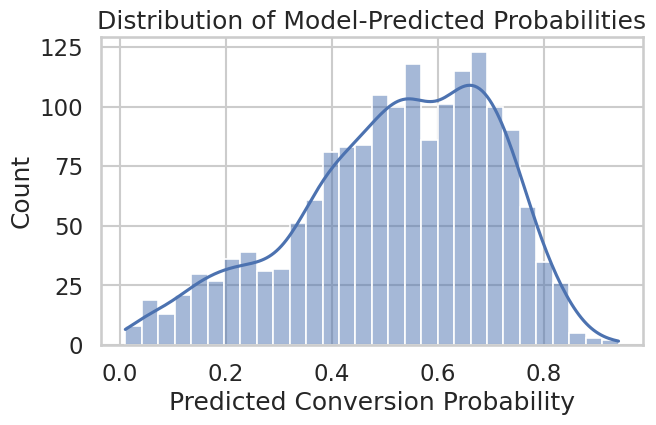

In [248]:
plt.figure(figsize=(7,4))
sns.histplot(y_prob, bins=30, kde=True)
plt.title("Distribution of Model-Predicted Probabilities")
plt.xlabel("Predicted Conversion Probability")
plt.show()


In [249]:
alias_map = {
    'SD':'LAC', 'OAK':'LV', 'STL':'LAR', 'LA':'LAR', 'WSH':'WAS'
}

# If needed, standardize team codes before plotting
if 'OffenseTeam' in attempts.columns:
    attempts = attempts.copy()
    attempts['OffenseTeam'] = attempts['OffenseTeam'].replace(alias_map)

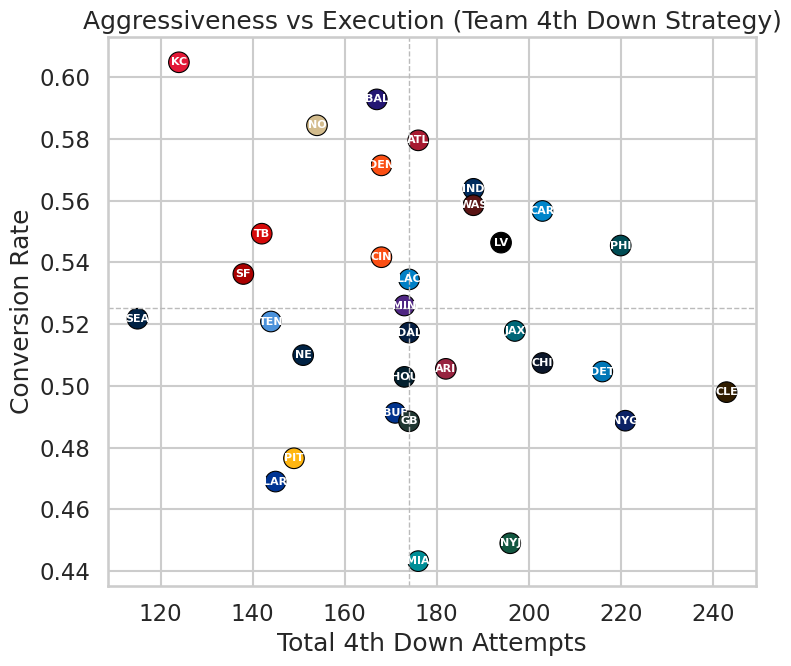

In [250]:
team_playstyle = attempts.groupby('OffenseTeam').agg(
    attempts=('FourthDownSuccess_simple','count'),
    conv_rate=('FourthDownSuccess_simple','mean')
).reset_index()

# Make a seaborn palette only for the teams present
present_teams = team_playstyle['OffenseTeam'].unique().tolist()
palette = {t: team_colors.get(t, '#888888') for t in present_teams}

plt.figure(figsize=(8,7))
ax = sns.scatterplot(
    data=team_playstyle,
    x='attempts', y='conv_rate',
    hue='OffenseTeam', palette=palette,
    s=220, edgecolor='black', linewidth=0.8, legend=False
)

for _, r in team_playstyle.iterrows():
    ax.text(
        r['attempts'], r['conv_rate'],
        r['OffenseTeam'],
        ha='center', va='center',
        fontsize=8, fontweight='bold', color='white'
    )

plt.xlabel("Total 4th Down Attempts")
plt.ylabel("Conversion Rate")
plt.title("Aggressiveness vs Execution (Team 4th Down Strategy)")

plt.axhline(team_playstyle['conv_rate'].mean(), color='#bbbbbb', ls='--', lw=1)
plt.axvline(team_playstyle['attempts'].median(), color='#bbbbbb', ls='--', lw=1)
plt.tight_layout()
plt.show()

